In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from tox21_project import deeplearning as dl
from tox21_project import testing as tt
from tox21_project import data_preprocessing as dp

## 1. 导入所有计算的文件，并做一个简单的观察

In [2]:
type_names = ['descriptors', 'fingerprint', 'similarity']
layers = [[1024],[1024,2048],[1024,2048,4196]]

# 模型名称
model_names = []
for t in type_names:
    for layer in layers:
        model_names.append(t + '_' + '_'.join([str(l) for l in layer]) + '_pca')
        model_names.append(t + '_' + '_'.join([str(l) for l in layer]))

In [3]:
# 模型计算结果，去除 val auprc 是null值的文件
model_drop_null = []
for m in model_names:
    if pd.read_csv('data/dnn_data/' + m + '.csv').isnull().sum()['val auprc'] != 0:
        continue
    else:
        model_drop_null.append(m)

In [4]:
len(model_drop_null)

18

画出模型计算val loss 和 val auprc 的曲线图

Text(0, 0.5, 'Valid Loss')

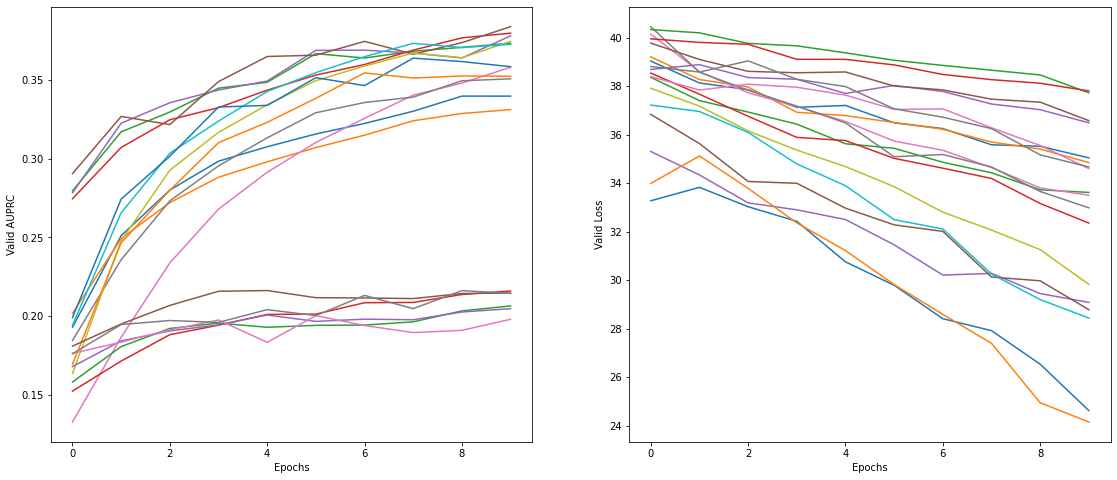

In [5]:
auprc = []
loss = []
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 8))

for m in model_drop_null:
    # 1. 读取数据
    filename = 'data/dnn_data/' + m + '.csv'
    df = pd.read_csv(filename, index_col=0)
    # 2. 取末尾5个epoch的平均值，作为后面的选取条件
    t = df.tail(5)[['val loss', 'val auprc']].mean().to_dict()
    auprc.append(t['val auprc'])
    loss.append(t['val loss'])
    # 3. 画图
    ax1.plot(df['val auprc'].values)
    ax2.plot(df['val loss'].values)

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Valid AUPRC')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Valid Loss')

## 2. 根据AUPRC选择合适的模型

In [6]:
# argsort 返回的是元素值从小到大排序后的索引值的数组
# [m::n]下标为m开始，间隔为n，来取元素
AUPRC = np.argsort(np.array(auprc))[::-1]
LOSS = np.argsort(np.array(loss))

In [7]:
np.array(auprc)[AUPRC]

array([0.37269209, 0.36922258, 0.36844816, 0.36752954, 0.36705782,
       0.36269699, 0.35624261, 0.34966823, 0.34071654, 0.33636899,
       0.32942799, 0.32108743, 0.21265757, 0.2097568 , 0.20962246,
       0.19994788, 0.19891336, 0.19455751])

In [9]:
final_model = model_drop_null[AUPRC[0]]
final_model

In [53]:
checkpoint = torch.load('models/dnn_models/' + final_model + '.pth')
final_model = checkpoint['model']

net(
  (dropout): Dropout(p=0.5, inplace=False)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=192, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=2048, bias=True)
    (2): Linear(in_features=2048, out_features=4196, bias=True)
  )
  (constant_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): Linear(in_features=2048, out_features=2048, bias=True)
    (2): Linear(in_features=4196, out_features=4196, bias=True)
  )
  (output): Linear(in_features=4196, out_features=12, bias=True)
  (bat): ModuleList(
    (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(4196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

## 3. 再训练

数据

In [20]:
targets = ['SR-HSE','NR-AR', 'SR-ARE', 'NR-Aromatase', 'NR-ER-LBD', 'NR-AhR', 'SR-MMP',\
       'NR-ER', 'NR-PPAR-gamma', 'SR-p53', 'SR-ATAD5', 'NR-AR-LBD']

# 读取数据，根据最后的模型来选取
raw_X = pd.read_csv('data/molecular_descriptors.csv', index_col=0).iloc[:, 2:]
raw_y = pd.read_csv('data/data_dups_removed.csv', index_col=0)[targets]

# 处理null
null_mask = np.array(np.logical_not(raw_y.isnull().values), int)
raw_y = raw_y.fillna(0.0)
mask_df = pd.DataFrame(null_mask, columns=[str(i) + '_mask' for i in targets], index=raw_y.index)
raw_y = pd.concat([raw_y, mask_df], axis=1)

# 分割
train_X, test_X, train_y, test_y = train_test_split(raw_X, raw_y, test_size=0.2, random_state=42)

# y和mask
train_y, train_mask = train_y[targets], train_y[mask_df.columns]
test_y, test_mask = test_y[targets], test_y[mask_df.columns]

In [22]:
def transform(train, test, apply):
    train_new = apply.fit_transform(train)
    test_new = apply.transform(test)
    return train_new, test_new
train_X, test_X = transform(train_X, test_X, StandardScaler())

In [23]:
def prepare_data(with_pca, train_X, train_y, train_mask, test_X, test_y, test_mask, batch_size):
    """PCA降维一半"""
    if with_pca:
        pca_shape = train_X.shape[1] // 2
        pca = PCA(pca_shape)
        train_X = pca.fit_transform(train_X)
        test_X = pca.transform(test_X)
    return dl.get_data(train_X, train_y, train_mask, test_X, test_y, test_mask, batch_size)

参数

In [24]:
epochs = 20
output_size = 12
optimizer = checkpoint['optimizer']
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 128

训练

In [27]:
def run(epochs, with_pca):
    # 数据获取
    train_set, valid_set, train_loader = prepare_data(with_pca, train_X, train_y, train_mask, test_X, test_y, test_mask, batch_size)
    input_size = len(train_set[0][0])
    
    # 参数设置
    criterion = nn.BCELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=False)
    early_stop = dl.EarlyStopping()
    trainer = dl.Trainer(final_model, optimizer, criterion, epochs, device, scheduler, early_stop)
    
    # 训练
    res = trainer.train_model(train_loader, valid_set, 'final_model')
    return res, valid_set

In [28]:
res, test_set = run(epochs, False)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20]----train loss: 23.210985  val loss: 27.107153  AUPRC: 0.386  AUCROC: 0.817
Epoch [11/20]----train loss: 14.201966  val loss: 17.801287  AUPRC: 0.425  AUCROC: 0.827


,train loss,val loss,val auprc,val aucroc
Epochs,,,,
1,23.210985,27.107153,0.385585,0.816953
2,22.40302,26.814953,0.386073,0.819789
3,21.438309,25.198221,0.381028,0.821559
4,20.592516,24.999472,0.396145,0.816208
5,19.793383,23.615158,0.396292,0.827865


In [31]:
res.tail()

,train loss,val loss,val auprc,val aucroc
Epochs,,,,
16,11.094129,13.481274,0.442341,0.836113
17,10.616943,13.085768,0.451231,0.837419
18,10.131408,11.803415,0.452852,0.842984
19,9.728772,11.716833,0.44306,0.836331
20,9.370594,10.597771,0.452954,0.83926


## 4. 测试和总结

In [51]:
X_test, y_test, mask_test = test_set[:]

test_panel = tt.panel_of_test(targets, y_test, mask_test)

y_scores = final_model(X_test.to(device).float()).cpu().detach().numpy() # 概率预测
y_pred = np.array(y_scores > 0.5, int) # 分类预测

metrics = test_panel.compute_basic_metrics(y_pred, y_scores)
metrics

  0%|          | 0/12 [00:00<?, ?it/s]

,Precision,Recall,F1,AUPRC,Accuracy,Balanced Accuracy,ROC_AUC
SR-HSE,0.36,0.130435,0.191489,0.267274,0.942293,0.558807,0.558807
NR-AR,0.848485,0.491228,0.622222,0.56444,0.977212,0.743872,0.743872
SR-ARE,0.7125,0.285,0.407143,0.567697,0.861782,0.631011,0.631011
NR-Aromatase,0.533333,0.235294,0.326531,0.36047,0.945137,0.61148,0.61148
NR-ER-LBD,0.645161,0.31746,0.425532,0.456084,0.962238,0.654707,0.654707
NR-AhR,0.733333,0.34375,0.468085,0.632237,0.908021,0.663535,0.663535
SR-MMP,0.811024,0.553763,0.658147,0.761536,0.909322,0.764809,0.764809
NR-ER,0.725806,0.298013,0.422535,0.481216,0.902458,0.641349,0.641349
NR-PPAR-gamma,0.2,0.026316,0.046512,0.160909,0.968678,0.511584,0.511584
SR-p53,0.676471,0.244681,0.359375,0.413434,0.940623,0.618067,0.618067


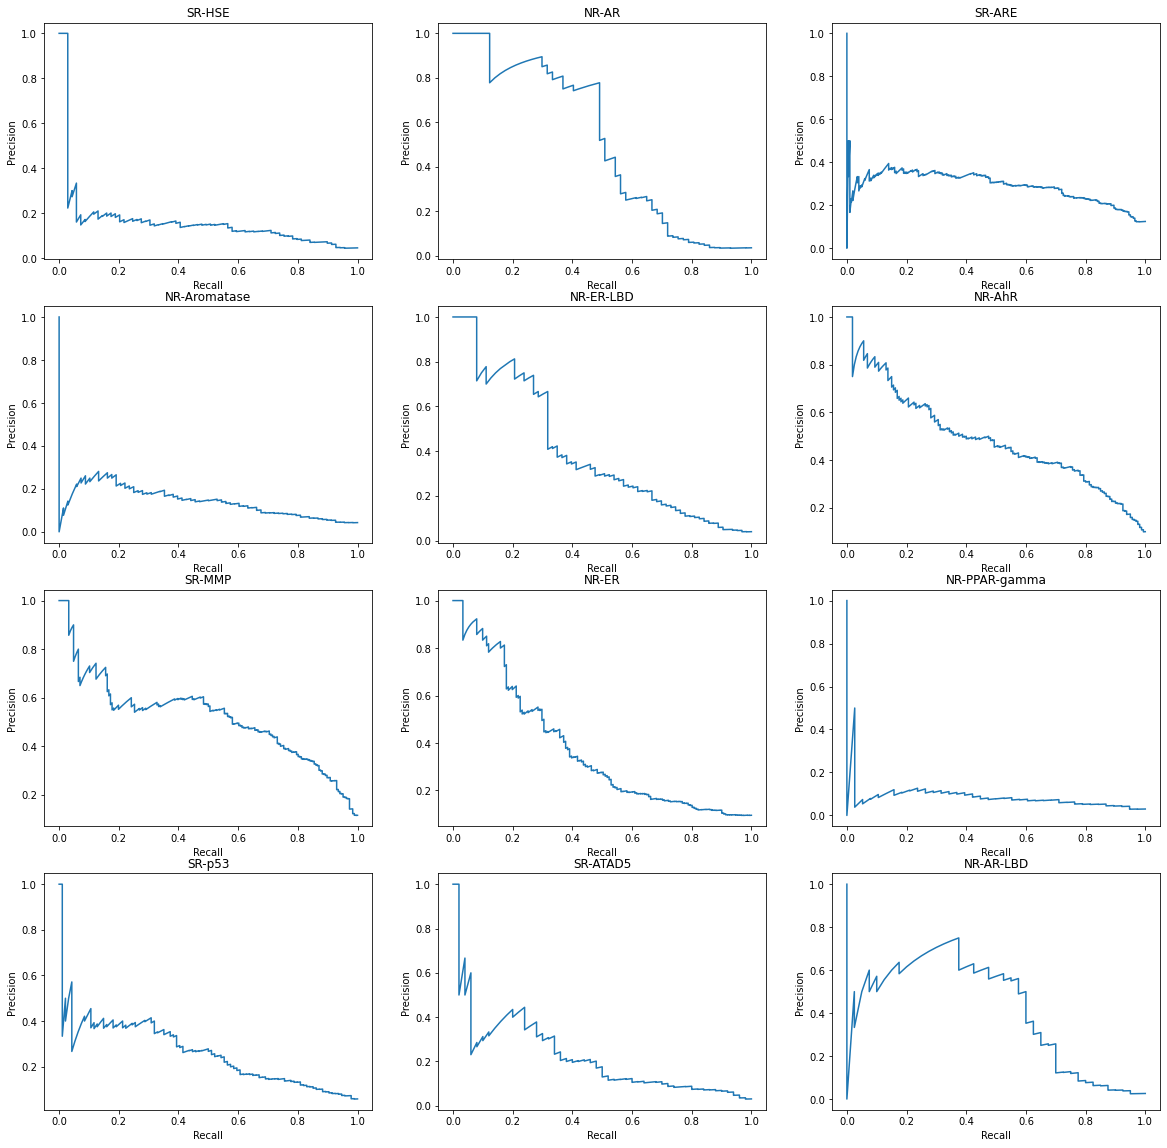

In [52]:
test_panel.plot_precision_recall(y_scores)